In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns" , 100)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold , KFold
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from tqdm import tqdm
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split

from autograd import grad as get_gradient
import sympy as sp
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pip-install-lifelines/fonttools-4.55.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/tzdata-2024.2-py2.py3-none-any.whl
/kaggle/input/pip-install-lifelines/kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
/kaggle/input/pip-install-lifelines/scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl
/kaggle/input/pip-install-lifelines/contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/pyparsing-3.2.0-py3-none-any.whl
/kaggle/input/pip-install-lifelines/wrapt-1.17.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/__results__.html
/kaggle/input/pip-install-lifelines/cycler-0.12.1-py3-n

In [ ]:

# !pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
# !pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

# # !pip install lifelines

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ac89a2552fb98cf5366b1bac69620013a0ef709a17907bd65443e7213324a2ad
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [3]:
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.290,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.230,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.810,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,NaN,ALL,6.0,-/-,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2018,No,Negative,Yes,Fully matched,2.0,No,24.212,Yes,2.0,No,51.136,2.0,FK+ MTX +- others(not MMF),NaN,M-F,2.0,More than one race,0.0,NaN,NaN,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,No,No,No,AML,3.0,-/+,6.0,2.0,G/G,4.0,1.0,No,2.0,2.0,PB,TBD,RIC,Hispanic or Latino,2017,No,Positive,No,NaN,1.0,No,30.770,No,1.0,No,18.075,2.0,Cyclophosphamide +- others,No,M-F,1.0,Native Hawaiian or other Pacific Islander,3.0,90.0,No,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,No,NaN,NaN,IPA,6.0,-/+,10.0,2.0,G/G,6.0,2.0,NaN,2.0,2.0,PB,Poor,MAC,Not Hispanic or Latino,2018,No,NaN,No,GvH non-permissive,2.0,No,22.627,No,2.0,NaN,51.005,2.0,FK+ MMF +- others,NaN,M-F,2.0,Native Hawaiian or other Pacific Islander,5.0,90.0,NaN,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,

In [4]:
import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

def evaluate(train = train , oof = None , scoring_func = score , print_=True):
    y_true = train[["ID","efs","efs_time","race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof
    m = scoring_func(y_true.copy(), y_pred.copy(), "ID")
    if print_:
        print(f"score is {m}")
    return m

In [5]:
default_efs_time = train["efs_time"].values
default_efs = train["efs"].values
default_groups = train["race_group"].astype("category").factorize()[0]

def evaluate_(pred = None  , indices = None ,groups = default_groups , efs = default_efs , efs_time = default_efs_time):
    efs_time = efs_time[indices]
    efs = efs[indices]
    in_groups = default_groups[indices]

    scores = np.zeros(6)
    for i in range(6):
        curr_indices = np.where(in_groups == i)[0]
        score_ = concordance_index(efs_time[curr_indices] 
                                   , -pred[curr_indices] 
                                   , efs[curr_indices])
        scores[i] = score_
    
    return np.mean(scores)-np.sqrt(np.var(scores))


# evaluate_(pred = pred , indices = train_test.index )

In [6]:
def evaluate(train = train , oof = None , scoring_func = score , print_=True):
    y_true = train[["ID","efs","efs_time","race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof
    m = scoring_func(y_true.copy(), y_pred.copy(), "ID")
    if print_:
        print(f"score is {m}")
    return m

# def wrap(indices = None):
#     def target_metric_(y_true , y_pred ):
#         score = evaluate_(pred = y_pred , indices = indices )
#         return 1-score
#     return target_metric_

def kfold_cv(model , X_train : pd.DataFrame, y_train:pd.Series,callback =None , callback_params = None , n_splits=5 , model_type = "xgb" , cat_features=None, verbose = 0 , scaler = None , use_tqdm = True , data =train , evaluate=False):
    # Initialize KFold
    add = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)                  
    oof_predictions = np.zeros(len(X_train))
    fold_iterator = enumerate(kf.split(X_train, y_train))
    if use_tqdm:
        fold_iterator = tqdm(fold_iterator, total=n_splits)        
    
    for fold, (train_idx, valid_idx) in fold_iterator:
        
        if isinstance(X_train, pd.DataFrame):
            X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]

            y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]


        

        model_ = clone(model)


        #FITTING LOGIC
        if model_type in ["xgb"]:
            callback_ = callback(**callback_params)
            callback_.testing_data = X_valid_fold
            model_.fit(X_train_fold , y_train_fold
                       ,eval_set=[(X_valid_fold , y_valid_fold)] 
                       , verbose = verbose , callbacks = [callback_])
            try:
                add.append(model_.best_iteration)
            except:
                add.append(0)
            
        elif model_type in ["lgbm"]:
            model_.fit(X_train_fold , y_train_fold,
                       eval_set=[(X_valid_fold, y_valid_fold)])
        elif model_type in ["catboost"]:
            model_.fit(X_train_fold , y_train_fold 
                       , cat_features = cat_features if cat_features else None
                      ,eval_set=[(X_train_fold , y_train_fold) ,(X_valid_fold, y_valid_fold)]
                      )

        else :
            model_.fit(X_train_fold , y_train_fold )

        
        pred = model_.predict(X_valid_fold).reshape(-1 ,)
        
        oof_predictions[valid_idx] = pred

    try:
        print(f"best_iterations -> {add} -> {float(np.mean(add))}")
    except:
        pass
    return oof_predictions

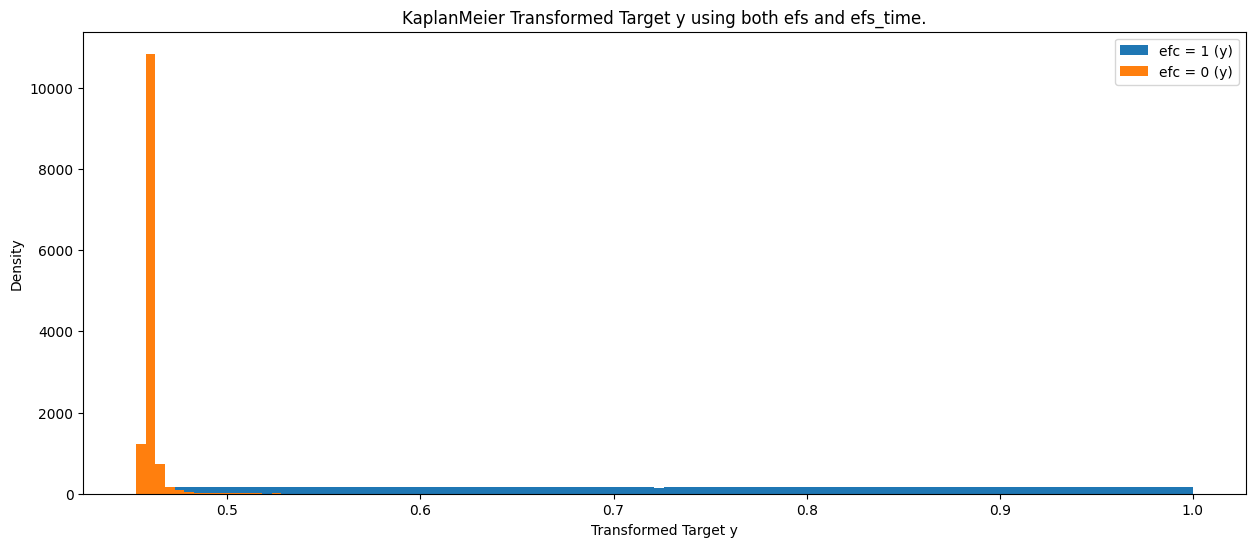

In [7]:
from lifelines import KaplanMeierFitter
def transform_target(time_col = "efs_time" , event_col = "efs" , data = train):
    kmp = KaplanMeierFitter()
    kmp.fit(data[time_col] , data[event_col])
    y_combined = kmp.survival_function_at_times(train[time_col]).values
    return y_combined

train["y"] = transform_target(time_col = "efs_time" , event_col = "efs" , data = train)

plt.figure(figsize = (15 , 6))
plt.hist(train.loc[train.efs==1 , "y"] , bins = 100 , label = "efc = 1 (y)")
plt.hist(train.loc[train.efs==0 , "y"] , bins = 100 , label = "efc = 0 (y)")

plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()


In [8]:
cat_features = train.select_dtypes(include=["object"]).columns
cat_features_2 = [col for col in train.columns if col not in ["donor_age" , "comorbidity_score" , "age_at_hct" , "year_hct"]]
com = pd.concat([train , test])
for cat_col in cat_features :
    com[cat_col] , _ = com[cat_col].factorize()
    com[cat_col]-= com[cat_col].min()


def tr(X):
    new = X.copy()
    cat_new = [x for x in cat_features if x in X.columns]
    new[cat_new] = new[cat_new].astype("category")
    return new


train_encoded = com.iloc[:len(train) , :]

test_encoded = com.iloc[len(train): , :]

train_encoded
    

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,1,1,0,1,NaN,NaN,0,1,6.0,0,1,1,1,0,6.0,1,NaN,2.0,0,6.0,2.0,1,2.0,2.0,0,0,0,1,2016,1,0,1,0,2.0,1,NaN,1,2.0,1,9.942,2.0,1,1,1,2.0,0,0.0,90.0,1,0,1,1,8.0,1,2.0,1,10.0,0.0,42.356,0.458687
1,1,2,1,1,1,2.0,8.0,1,1,6.0,1,1,1,1,1,6.0,1,10.0,2.0,1,6.0,2.0,1,2.0,2.0,1,1,1,1,2008,1,1,2,1,2.0,1,72.290,1,2.0,1,43.705,2.0,2,1,2,2.0,1,3.0,90.0,1,1,2,1,8.0,1,2.0,2,10.0,1.0,4.672,0.847759
2,2,1,1,0,1,2.0,8.0,0,1,6.0,0,1,1,1,2,6.0,1,10.0,2.0,1,6.0,2.0,1,2.0,2.0,0,0,0,1,2019,1,0,1,0,2.0,1,NaN,1,2.0,1,33.997,2.0,3,1,3,2.0,0,0.0,90.0,1,1,2,1,8.0,1,2.0,1,10.0,0.0,19.793,0.462424
3,3,3,1,1,1,2.0,8.0,0,1,6.0,0,1,1,1,3,6.0,1,10.0,2.0,1,6.0,2.0,1,2.0,2.0,0,1,1,1,2009,1,1,2,1,2.0,1,29.230,1,2.0,1,43.245,2.0,4,1,4,2.0,2,0.0,90.0,2,1,1,1,8.0,1,2.0,1,10.0,0.0,102.349,0.456661
4,4,3,1,0,1,2.0,8.0,0,1,6.0,1,1,1,1,4,6.0,1,10.0,2.0,0,5.0,2.0,1,2.0,2.0,1,0,1,2,2018,1,0,1,0,2.0,1,56.810,1,2.0,1,29.740,2.0,5,1,1,2.0,3,1.0,90.0,1,1,2,2,8.0,1,2.0,1,10.0,0.0,16.223,0.464674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,8,0,4,1,2.0,8.0,0,1,6.0,1,1,1,0,3,6.0,3,10.0,2.0,1,6.0,2.0,1,2.0,2.0,1,1,1,1,2018,1,2,1,3,2.0,1,24.212,2,2.0,1,51.136,2.0,8,0,1,2.0,0,0.0,NaN,0,4,0,1,8.0,0,2.0,1,10.0,0.0,18.633,0.462846
28796,28796,3,1,2,2,1.0,4.0,0,1,5.0,1,1,1,1,1,3.0,2,6.0,2.0,4,4.0,1.0,1,2.0,2.0,1,2,2,2,2017,1,1,2,0,1.0,1,30.770,1,1.0,1,18.075,2.0,9,1,1,1.0,4,3.0,90.0,1,2,2,1,6.0,2,1.0,2,8.0,1.0,4.892,0.825494
28797,28797,7,0,2,0,2.0,8.0,0,0,6.0,1,1,0,0,9,6.0,2,10.0,2.0,4,6.0,2.0,0,2.0,2.0,1,3,1,1,2018,1,0,2,4,2.0,1,22.627,1,2.0,0,51.005,2.0,4,0,1,2.0,4,5.0,90.0,0,2,1,1,8.0,0,2.0,1,10.0,0.0,23.157,0.461142
28798,28798,1,1,2,1,1.0,4.0,0,1,3.0,1,1,0,0,9,3.0,1,5.0,1.0,1,3.0,1.0,1,1.0,1.0,1,0,3,1,2018,0,0,1,0,1.0,1,58.074,2,1.0,0,0.044,1.0,3,1,4,1.0,5,1.0,90.0,1,1,2,2,4.0,1,1.0,1,5.0,0.0,52.351,0.458404


In [9]:
def tr(X):
    new = X.copy()
    cat_new = [x for x in cat_features if x in X.columns]
    new[cat_new] = new[cat_new].astype("category")
    return new

In [10]:
def ranking_loss(y_true, preds, a):
    sign = np.sign(rankdata(preds)-rankdata(y_true))
    term1 = sign * (3 * np.cos(preds) * (sign * (-np.sin(y_true) + np.sin(preds))) ** (a - 1))
    term2 = sign * (3 * np.sin(preds) * (sign * (-np.cos(y_true) + np.cos(preds))) ** (a - 1))
    return term1 - term2
    
def get_hess(y_true , preds , a , sign = 1):
    if sign == -1:
        sign_neg = (
                3 * (a - 1) * (-np.cos(preds) + np.cos(y_true))**(a - 1) * np.sin(preds)**2 / (-np.cos(preds) + np.cos(y_true)) +
                3 * (a - 1) * (-np.sin(preds) + np.sin(y_true))**(a - 1) * np.cos(preds)**2 / (-np.sin(preds) + np.sin(y_true)) +
                3 * (-np.sin(preds) + np.sin(y_true))**(a - 1) * np.sin(preds) +
                3 * (-np.cos(preds) + np.cos(y_true))**(a - 1) * np.cos(preds)
            )
        return sign_neg
    elif sign==1:

        sign_positive = (
                3 * (a - 1) * (np.cos(preds) - np.cos(y_true))**(a - 1) * np.sin(preds)**2 / (np.cos(preds) - np.cos(y_true)) +
                3 * (a - 1) * (np.sin(preds) - np.sin(y_true))**(a - 1) * np.cos(preds)**2 / (np.sin(preds) - np.sin(y_true)) -
                3 * (np.sin(preds) - np.sin(y_true))**(a - 1) * np.sin(preds) -
                3 * (np.cos(preds) - np.cos(y_true))**(a - 1) * np.cos(preds)
            )
        return sign_positive
    else :
        return None
        
    



def ranking_sine_loss(y_true , preds , a = 2.5):
     # print("loss_switched" , end="\r")
     sign = np.sign(rankdata(preds) - rankdata(y_true))
     grad = ranking_loss(y_true , preds , a)
     hess = np.where(
         sign==1,
         get_hess(y_true , preds , 2 , sign = 1),
         get_hess(y_true , preds , 2 , sign = -1)
     )
     return grad , hess


In [11]:
def combine_cols(data = None ,col1 =None , col2=None):
    combined_cols = data[col1].astype(str) + "_" + data[col2].astype(str)
    return combined_cols.astype("category")

def add_interactions(data :pd.DataFrame = None , cols :list[tuple]=None)->pd.DataFrame:
    data = data.copy()
    new_data = {f"{col1}_{col2}" :combine_cols(data = data , col1 =col1 , col2 = col2)
                    for col1 , col2 in cols}
    df_new = pd.concat([data , pd.DataFrame(new_data)] , axis = 1)
    return df_new


In [12]:
num_col = ["hla_match_c_high" , "hla_high_res_8" , "hla_low_res_6" , "hla_high_res_6"]
cols_int = [("sex_match" , "race_group")]

In [13]:
train_encoded_f = train_encoded.copy()
test_encoded_f = test_encoded.copy()
train_encoded_f["isnull"] = train_encoded_f.isnull().sum(axis = 1)
train_encoded_f["feat"]=train_encoded_f[num_col].mean(axis =1)


test_encoded_f["isnull"] = test_encoded_f.isnull().sum(axis = 1)
test_encoded_f["feat"]=test_encoded_f[num_col].mean(axis =1)
# train_encoded_f = add_interactions(data = train_encoded_f , cols =cols_int)
# train_encoded_f = train_encoded_f.drop(["melphalan_dose" , "rheum_issue" 
#                                         , "renal_issue" , "obesity" ] , axis = 1)
# train_encoded_f

In [14]:
columns_to_drop = ["ID" , "efs_time" , "efs" , "y"]

X = train_encoded_f.drop(columns_to_drop , axis = 1)
y = train_encoded_f["y"]

train_encoded_f["efs_time_2"] =train_encoded_f["efs_time"].copy()
train_encoded_f.loc[train_encoded_f.efs==0 , "efs_time_2"]*=-1

y_cox = train_encoded_f["efs_time_2"]

test_data = test_encoded_f.drop(columns_to_drop , axis = 1)

X_train , X_test , y_train , y_test = train_test_split(tr(X) , y 
                                                       , test_size = 0.2 , random_state = 42)

train_train , train_test = train_test_split(train ,
                                        test_size = 0.2 , random_state = 42)

X_test


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,isnull,feat
18932,3,1,2,1,2.0,7.0,0,3,5.0,0,1,1,1,9,5.0,1,9.0,2.0,1,6.0,2.0,1,1.0,2.0,1,3,2,1,2012,1,2,2,0,2.0,1,70.867,1,2.0,1,50.961,2.0,9,1,3,2.0,3,4.0,90.0,1,1,2,1,7.0,2,1.0,2,9.0,0,4.75
21280,2,1,1,1,2.0,8.0,0,1,6.0,1,1,1,0,3,6.0,1,10.0,2.0,0,6.0,2.0,1,2.0,2.0,1,0,5,1,2017,1,0,2,0,2.0,0,23.287,1,2.0,1,52.305,2.0,4,1,3,2.0,5,0.0,NaN,1,0,1,0,8.0,1,2.0,1,10.0,1,5.50
27880,3,1,1,2,2.0,7.0,0,1,5.0,0,2,1,1,1,5.0,2,9.0,2.0,1,4.0,2.0,1,1.0,2.0,0,1,2,1,2016,1,2,2,0,2.0,1,30.994,1,2.0,1,63.212,2.0,3,1,2,2.0,4,6.0,70.0,2,1,2,1,7.0,2,1.0,2,9.0,0,4.75
15692,1,1,2,2,1.0,4.0,0,1,4.0,1,1,1,1,11,3.0,1,5.0,1.0,1,5.0,2.0,1,1.0,2.0,1,3,1,1,2018,2,2,2,0,1.0,1,50.309,2,2.0,1,53.097,1.0,9,1,4,1.0,1,5.0,40.0,1,1,2,2,6.0,1,1.0,1,8.0,0,3.00
25416,3,1,2,0,2.0,8.0,0,0,6.0,1,1,0,0,11,6.0,1,10.0,2.0,1,6.0,2.0,1,2.0,2.0,1,3,1,1,2016,1,0,1,0,2.0,0,57.013,1,2.0,0,58.100,2.0,8,0,1,2.0,0,2.0,60.0,1,1,2,1,8.0,0,2.0,0,10.0,0,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,5,1,0,1,1.0,4.0,2,1,3.0,1,1,1,2,3,3.0,1,5.0,1.0,1,3.0,1.0,1,1.0,2.0,1,0,3,1,2018,1,0,2,0,1.0,1,24.614,1,1.0,1,32.526,1.0,3,1,2,1.0,0,4.0,90.0,1,1,2,1,4.0,1,1.0,1,6.0,0,2.75
9986,6,1,0,1,2.0,8.0,0,1,6.0,1,1,1,1,0,6.0,1,10.0,2.0,7,6.0,2.0,1,2.0,2.0,1,0,0,1,2016,1,0,1,0,2.0,1,57.247,1,2.0,1,12.476,2.0,1,1,1,2.0,0,1.0,80.0,1,0,2,2,8.0,1,2.0,1,10.0,0,5.50
1604,7,1,0,1,2.0,8.0,0,1,6.0,0,1,1,1,0,6.0,4,10.0,2.0,1,6.0,2.0,1,2.0,2.0,0,0,0,1,2018,1,0,1,0,2.0,2,NaN,1,2.0,1,6.550,2.0,1,2,4,2.0,1,0.0,90.0,2,1,2,1,8.0,1,2.0,2,10.0,1,5.50
19463,2,3,2,1,2.0,8.0,0,1,6.0,1,1,1,1,1,6.0,4,10.0,2.0,4,6.0,2.0,1,2.0,2.0,1,3,1,1,2017,1,2,2,0,2.0,1,63.472,1,2.0,1,57.731,2.0,4,1,4,2.0,1,2.0,90.0,1,2,2,1,8.0,1,2.0,1,10.0,0,5.50


In [15]:
def target_metric_(y_true , y_pred , indices = train_test.index):
        score = evaluate_(pred = y_pred , indices =indices )
        return 1 - score 
def ranking_sine_loss(y_true , preds , a = 2):
     # print("loss_switched" , end="\r")
     sign = np.sign(rankdata(preds) - rankdata(y_true))
     grad = ranking_loss(y_true , preds , a)
     hess = np.where(
         sign==1,
         get_hess(y_true , preds , a , sign = 1),
         get_hess(y_true , preds , a , sign = -1)
     )
     return grad , hess

def mse_loss(y_true , preds):
    grad = 2*(preds - y_true)
    hess = np.full_like(y_true , 2)
        
    return grad , hess

def limited_mae_loss(limit = 0.05):
    def mae_loss(y_true , preds ):
        residual = preds - y_true
        grad = np.sign(residual)
        hess = np.full_like(y_true , 2)
        
        grad = np.where(
            np.abs(residual)<=limit,
            grad,
            0
        )

        hess = np.where(
            np.abs(residual)<=limit,
            hess,
            0
        )
    
        return grad , hess
    return mae_loss
def mse_limited_wrapper(deviation = 0.05):
    def mse_limited(y_true , preds , deviation = deviation):
        residual = preds - y_true
        grad = preds - y_true
        hess = np.ones_like(y_true)
    
        grad = np.where(
            np.abs(y_true-preds)<deviation,
            grad,
            0
        )
    
        hess = np.where(
            np.abs(y_true-preds)<deviation,
            hess,
            0
        )
    
        
    
        return grad , hess
    return mse_limited



def ranking_log_loss(y_true , preds , a  = 1000):
    sign = np.sign(y_true - preds) #1 if y_true > preds , -1 if y_true<preds
    grad = np.where(
        sign==1,
        -a/(0.01+a*(-preds+y_true)), #b>x
        a/(0.01+a*(preds-y_true)) #x>b
    )


    hess = np.where(
        sign==1,
        -(a)**2/(0.01+a*(-preds+y_true))**2, #b>x
        -(a)**2/(0.01+a*(preds-y_true))**2 #x>b
    )

    return grad , hess


In [16]:
import xgboost as xgb
from collections import OrderedDict

class DynamicLoss:
    def __init__(self, switch_epoch , first_loss=mse_loss , second_loss = None , third_loss =None):
        self.switch_epoch = switch_epoch  # Epoch to switch loss
        self.current_loss = first_loss       # Start with loss_1
        self.second_loss = second_loss
        self.third_loss = third_loss
        self.loss_switched = False
    def __call__(self, y_true, preds):
        return self.current_loss(y_true, preds)


    def switch_loss(self):
        if not self.loss_switched:
            self.current_loss = self.second_loss if self.second_loss is not None else self.current_loss 
            self.loss_switched = True
        else :
            self.current_loss = self.third_loss if self.third_loss is not None else self.second_loss


class EpochAwareCallback(xgb.callback.TrainingCallback):
    def __init__(self , initial_lr=0.1 , verbose = 100 , dynamic_loss = None , testing_data = None , decay_at = 300 , decay_rate = 0.1 , perform_decay = False):

        self.initial_lr = initial_lr
        self.verbose = verbose
        self.dynamic_loss = dynamic_loss
        self.switch_epoch = dynamic_loss.switch_epoch if dynamic_loss is not None else None
        self.testing_data = testing_data
        self.decay_at = decay_at
        self.decay_rate = decay_rate
        self.perform_decay = perform_decay
        self.eval_log = None

    def learning_rate_decay(self , epoch , decay_rate=0.01):
        return self.initial_lr* (1.0 / (1.0 + decay_rate * epoch))


    
    def target_metric_(self , y_true , y_pred , indices = None):
        score = evaluate_(pred = y_pred , indices =indices )
        return score 

    def c_index_metric(self ,model , testing_data= None):
        dtest = xgb.DMatrix(testing_data , enable_categorical=True)
        pred = model.predict(dtest)
        
        return self.target_metric_( pred, pred , indices = testing_data.index)

    def perform_lr_decay(self ,model, epoch):
        epoch_to_decay_at = self.decay_at
        if epoch > epoch_to_decay_at:
            new_learning_rate = self.learning_rate_decay(epoch - epoch_to_decay_at 
                                                         , decay_rate = self.decay_rate) 
            if self.switch_epoch == epoch:
                new_learning_rate = self.learning_rate_decay(epoch - self.switch_epoch 
                                             , decay_rate = self.decay_rate) 
                
            model.set_param('learning_rate', new_learning_rate)

    def after_iteration(self, model, epoch, evals_log):
        if not self.verbose==0:
            if epoch%self.verbose==0:
                
                c_index = self.c_index_metric(model ,testing_data =  self.testing_data)
                if epoch==0:
                    evals_log["validation_0"]["c_index"] = [c_index]
                    evals_log["validation_0"].move_to_end('c_index', last=False)
                else:
                    evals_log["validation_0"]["c_index"].append(c_index)
                    self.eval_log = evals_log["validation_0"]["c_index"]
                

        if self.perform_decay:
            self.perform_lr_decay(model , epoch)
            

        epoch_to_switch_loss_1 = self.switch_epoch[0]
        epoch_to_switch_loss_2 = self.switch_epoch[1]
        
        
        if (epoch == epoch_to_switch_loss_1) or (epoch == epoch_to_switch_loss_2) and not self.switch_epoch is None :
            # print("loss_swiched")
            self.dynamic_loss.switch_loss()
            model.set_param('max_depth', 11)
            model.set_param('colsample_bytree', .35042075533001182 )#0.4342075533001182  #35042075533001182
            # model.set_param('learning_rate', new_learning_rate)

        return False

    


In [17]:
def ln_cosh_loss(y_true, y_pred):
    # Calculate the absolute error
    error = np.abs(y_true - y_pred)
    
    # Calculate the gradient (first derivative of the loss)
    grad = np.sign(y_pred - y_true) * np.sinh(error)
    
    # Calculate the hessian (second derivative of the loss)
    hess = np.cosh(error)
    
    return grad, hess



def ln_cosh_loss_wrapper(a = 1 , limit=np.inf):
    def ln_cosh_loss_with_a(y_true, y_pred, a=a):
        # Calculate the absolute error, scaled by 'a'
        error = np.abs(y_true - y_pred)
        scaled_error = a * error  # Apply scaling factor
    
        # Calculate the gradient (first derivative of the loss)
        grad = -a * np.sign(y_true - y_pred) * np.sinh(scaled_error)
    
        # Calculate the hessian (second derivative of the loss)
        hess = a**2 * np.cosh(scaled_error)

        grad = np.where(
            error<=limit,
            grad,
            0
        )


        hess = np.where(
            error<=limit,
            hess,
            0
        )
    
        return grad, hess
    return ln_cosh_loss_with_a

In [18]:
def get_oof(X , y , params = None):
        model_2 = XGBRegressor(
        **{'objective': "reg:squarederrror",
                        'max_depth': 8,#8
                        'min_child_weight': 88,
                        'gamma': 0.08191438618604895,
                        'subsample': 0.709785867220118,
                        'colsample_bytree': 0.5342075533001182,#0.5342075533001182
                        "learning_rate": 0.02,
                        "n_estimators": 2500,
                        'enable_categorical':True,
                        'random_state':42}  , eval_metrics = None
                        # , early_stopping_rounds=2300
        )


        n_splits = 10
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        oof_predictions = np.zeros(len(X))  # Assuming X_train is already defined



        best_iterations = []
        for fold, (train_idx, valid_idx) in tqdm(enumerate(kf.split(tr(X) ,y)) , total=n_splits):
            # Split the data
            X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
            y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

            model_ =clone(model_2)


            dynamic_loss = DynamicLoss(switch_epoch=(1850 , np.inf) 
                                , first_loss =ln_cosh_loss_wrapper(a=1 ) 
                                    ,second_loss = ln_cosh_loss_wrapper(a=11 , limit=0.05)
                                    )

            model_.objective = dynamic_loss


            callbacks = [EpochAwareCallback(
                                        perform_decay = True
                                        ,initial_lr = 0.01
                                        , dynamic_loss = dynamic_loss
                                        ,verbose = 99
                                        , testing_data = X_valid_fold 
                                        , decay_at = 1850
                                        ,decay_rate=0
                                        ) ] 
            model_.callbacks = callbacks

            model_.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_valid_fold, y_valid_fold)],  
                verbose=0,
                # callbacks = callbacks
                
            )

            
            oof_preds = model_.predict(X_valid_fold).reshape(-1,)
            oof_predictions[valid_idx] = oof_preds
        return oof_predictions , evaluate_(pred = oof_predictions  , indices = X.index)

In [19]:
# columns = X.columns
# columns_to_drop =  ['hla_low_res_8', 'hla_high_res_8', 'hla_high_res_8', 'hla_high_res_6', 'race_group', 'tce_imm_match', 'peptic_ulcer', 'hepatic_severe'] 
# X_exp = tr(X.copy()).drop(columns_to_drop , axis = 1)
# oof , eval_ = get_oof(X_exp , y)
# eval_

In [20]:
# !pip install --upgrade xgboost==2.1.3

In [21]:
dynamic_loss = DynamicLoss(switch_epoch=(1850 , np.inf) 
                    , first_loss =ln_cosh_loss_wrapper(a=1 ) 
                        ,second_loss = ln_cosh_loss_wrapper(a=11 , limit=0.05)
                        )



callbacks = [EpochAwareCallback(
                            perform_decay = True
                            ,initial_lr = 0.01
                            , dynamic_loss = dynamic_loss
                            ,verbose = 0
                            , testing_data = None 
                            , decay_at = 1850
                            ,decay_rate=0
                            ) ] 

model_xgb = XGBRegressor(
        **{'objective': dynamic_loss,
                        'max_depth': 8,#8
                        'min_child_weight': 88,
                        'gamma': 0.08191438618604895,
                        'subsample': 0.709785867220118,
                        'colsample_bytree': 0.5342075533001182,#0.5342075533001182
                        "learning_rate": 0.02,
                        "n_estimators": 2500,
                        'enable_categorical':True,
                        'random_state':42} , device = "cuda" , eval_metrics = None , callbacks = callbacks
                        # , early_stopping_rounds=2300
        )
columns_to_drop =  ['hla_low_res_8', 'hla_high_res_8', 'hla_high_res_8', 'hla_high_res_6', 'race_group', 'tce_imm_match', 'peptic_ulcer', 'hepatic_severe'] 
X_exp = tr(X.copy()).drop(columns_to_drop , axis = 1)
test_exp = (tr(test_data.copy())).drop(columns_to_drop , axis = 1)

model_xgb.fit(
    X_exp , y , verbose = 0
)

pred_xgb = model_xgb.predict(test_exp)
pred_xgb


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:31:57] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


array([0.37475598, 0.7740134 , 0.4050136 ], dtype=float32)

In [22]:
submission = pd.DataFrame(
    {
        "ID":test["ID"],
        "prediction":pred_xgb
    }
)
submission.to_csv("submission.csv" , index = False)